# Assignment 1 D

### Import necessary modules

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Layer class

In [2]:
class Layer:
    def __init__(self, neurons_size: int, inputs_size: int, activation: str = 'sigmoid',
                 leaky_slope: float = 0.01, softmax_dim: int = 0):
        '''
        Initialize the layer with random weights and biases

        Parameters:
            neurons_size: int
                The number of neurons in the layer
            inputs_size: int
                The number of inputs to the layer
            activation: str
                The activation function to use
            leaky_slope: float
                The slope of the leaky relu activation function
            softmax_dim: int
                The dimension of the softmax activation function
        '''

        # initialize weights and biases with random values
        # use the He initialization method to initialize the weights if the activation function is relu or leaky relu else use the Xavier initialization method
        if activation == 'relu' or activation == 'leaky_relu':
            self._weights: torch.Tensor = torch.randn(
                neurons_size, inputs_size) * torch.sqrt(2 / torch.tensor(inputs_size, dtype=torch.float32))
        else:
            self._weights: torch.Tensor = torch.randn(
                neurons_size, inputs_size) * torch.sqrt(1 / torch.tensor(inputs_size, dtype=torch.float32))
        self._biases: torch.Tensor = torch.zeros(neurons_size)
        self._activation: str = activation
        self._leaky_slope: float = leaky_slope
        self._softmax_dim: int = softmax_dim

        self._activation_function: dict[str, callable] = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(negative_slope=self._leaky_slope),
            'softmax': nn.Softmax(dim=self._softmax_dim),
            'none': nn.Identity()
        }

    def set_weights(self, weights: torch.Tensor):
        '''
        Set the weights of the layer

        Parameters:
            weights: torch.Tensor
                The weights to set
        '''
        self._weights = weights

    def get_weights(self) -> torch.Tensor:
        '''
        Get the weights of the layer

        Returns:
            torch.Tensor
                The weights of the layer
        '''
        return self._weights

    def set_biases(self, biases: torch.Tensor):
        '''
        Set the biases of the layer

        Parameters:
            biases: torch.Tensor
                The biases to set
        '''
        self._biases = biases

    def get_biases(self) -> torch.Tensor:
        '''
        Get the biases of the layer

        Returns:
            torch.Tensor
                The biases of the layer
        '''
        return self._biases

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass

        Parameters:
            inputs: torch.Tensor
                The inputs to the layer
            activation: str
                The activation function to use
        Returns:
            torch.Tensor
                The outputs of the layer
        '''
        # calculate the sum of the inputs multiplied by the weights and add the biases
        if inputs.dim() == 2:
            sum: torch.Tensor = torch.matmul(
                inputs, self._weights.t()) + self._biases
        else:
            sum: torch.Tensor = torch.matmul(
                inputs, self._weights) + self._biases

        if self._activation in self._activation_function:
            return self._activation_function[self._activation](sum)
        else:
            raise ValueError(
                f"Activation function {self._activation} not found")



### Custom Layer class

In [3]:
# custom layer class to use the Layer class as a custom layer in PyTorch
class CustomLayer(nn.Module):
    def __init__(self, neurons_size: int, inputs_size: int, activation: str = 'sigmoid',
                 leaky_slope: float = 0.01, softmax_dim: int = 0):
        super(CustomLayer, self).__init__()

        '''
        Initialize the custom layer with the given neurons size, inputs size, 
        activation, leaky slope, and softmax dimension

        '''

        # initialize the custom layer
        self.layer = Layer(neurons_size, inputs_size,
                           activation, leaky_slope, softmax_dim)

        # register the weights and biases as parameters to PyTorch
        self.weights = nn.Parameter(self.layer.get_weights())
        self.biases = nn.Parameter(self.layer.get_biases())

        # point the layer parameters to the PyTorch parameters
        self.layer.set_weights(self.weights)
        self.layer.set_biases(self.biases)

        # store the activation function parameters
        self.activation = activation
        self.leaky_slope = leaky_slope
        self.softmax_dim = softmax_dim

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:

        # use custom layer forward method
        return self.layer.forward(inputs)

### Perceptron class

In [4]:
class Perceptron(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, hidden_activation: str = 'relu',
                 output_activation: str = 'softmax', leaky_slope: float = 0.01, softmax_dim: int = 0):
        super(Perceptron, self).__init__()

        '''
        Initialize the perceptron with the given input size, hidden size, output size, 
        hidden activation, output activation, leaky slope, and softmax dimension

        Parameters:
            input_size: int
                The size of the input layer
            hidden_size: int
                The size of the hidden layer
            output_size: int
                The size of the output layer
            hidden_activation: str
                The activation function to use for the hidden layer
            output_activation: str
                The activation function to use for the output layer
            leaky_slope: float
                The slope of the leaky relu activation function
            softmax_dim: int
                The dimension of the softmax activation function
        '''

        # create a list of layer sizes including the input and output sizes
        layer_sizes: list[int] = [input_size] + hidden_size + [output_size]
        layers: list[CustomLayer] = []

        # create hidden layers
        for i in range(len(layer_sizes) - 2):
            layers.append(CustomLayer(
                layer_sizes[i+1], layer_sizes[i], hidden_activation, leaky_slope, softmax_dim))

        # create output layer
        layers.append(CustomLayer(
            layer_sizes[-1], layer_sizes[-2], output_activation, leaky_slope, softmax_dim))

        # store the layers
        self.layers = nn.ModuleList(layers)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass

        Parameters:
            inputs: torch.Tensor
                The inputs to the perceptron

        Returns:
            torch.Tensor
            The outputs of the perceptron
        '''

        # process the input through the layers
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

### Test Training in GPU with graphs

Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda

Starting training...
Epoch [1/10], Step [100/938], Loss: 0.4322
Epoch [1/10], Step [200/938], Loss: 0.3024
Epoch [1/10], Step [300/938], Loss: 0.3595
Epoch [1/10], Step [400/938], Loss: 0.2423
Epoch [1/10], Step [500/938], Loss: 0.2881
Epoch [1/10], Step [600/938], Loss: 0.3294
Epoch [1/10], Step [700/938], Loss: 0.3723
Epoch [1/10], Step [800/938], Loss: 0.2187
Epoch [1/10], Step [900/938], Loss: 0.1286
Epoch [1/10], Loss: 0.3607

Epoch [2/10], Step [100/938], Loss: 0.4463
Epoch [2/10], Step [200/938], Loss: 0.1599
Epoch [2/10], Step [300/938], Loss: 0.3721
Epoch [2/10], Step [400/938], Loss: 0.2644
Epoch [2/10], Step [500/938], Loss: 0.2724
Epoch [2/10], Step [600/938], Loss: 0.2156
Epoch [2/10], Step [700/938], Loss: 0.1613
Epoch [2/10], Step [800/938], Loss: 0.1414
Epoch [2/10], Step [900/938], Loss: 0.1897
Epoch [2/10], Loss: 0.1879

Epoch [3/10], Step [100/938], Loss: 0.1784
Epoch [3/10], St

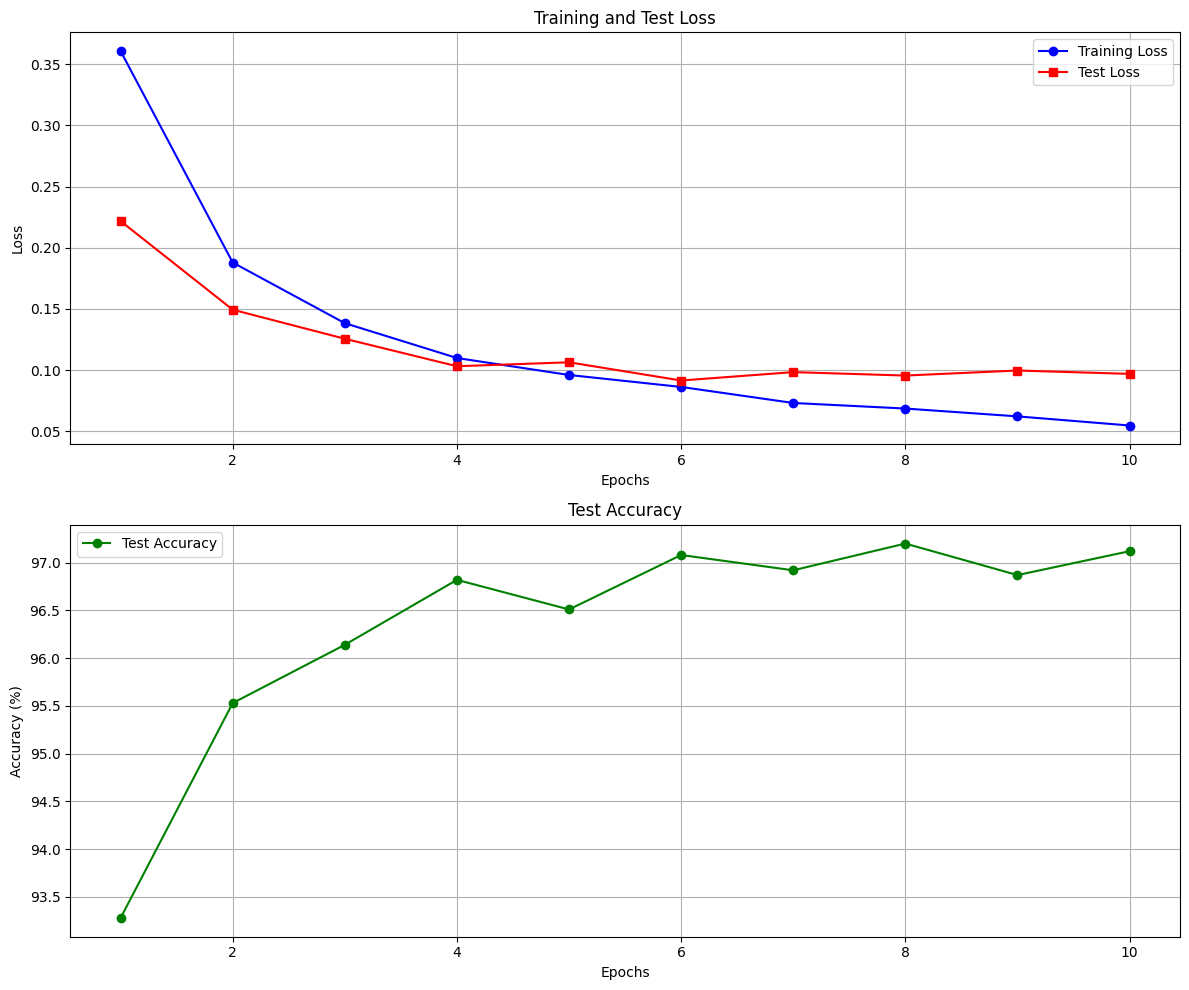

In [5]:
# set the random seed for reproducibility
torch.manual_seed(42)

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f'Number of GPUs available: {num_gpus}')
    for i in range(num_gpus):
        print(f'GPU {i}: {torch.cuda.get_device_name(i)}')
else:
    print('CUDA is not available.')

# get the device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')

# define the transformations to apply to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# create the data loaders
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, pin_memory=True)

# create the model
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = [128]  # one hidden layer
output_size = 10  # 10 classes (digits 0-9)
model = Perceptron(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    hidden_activation='relu',
    output_activation='none',
    softmax_dim=-1
).to(device)

# define the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# lists to store metrics for visualization
train_losses = []
test_losses = []
test_accuracies = []

# training loop
num_epochs = 10
print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # flatten the images
        images = images.view(-1, input_size).to(device)
        labels = labels.to(device)

        # forward propagation
        outputs = model.forward(images)
        loss = criterion(outputs, labels)

        # back propagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate the running loss for the training set
        running_loss += loss.detach().item()

        # print the loss for the training set every 100 steps
        if (i+1) % 100 == 0:
            print(
                f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.detach().item():.4f}')

    # calculate the average loss for the training set
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}\n')

    # evaluate on test set after each epoch (without printing during training)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0.0

        for images, labels in test_loader:
            images = images.view(-1, input_size).to(device)
            labels = labels.to(device)
            outputs = model.forward(images)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * correct / total
        
        # Store metrics for visualization
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

print("Training complete!")

# evaluate the model
model.eval()
with torch.no_grad():
    correct = 0  # correct predictions
    total = 0  # total samples
    test_loss = 0.0  # running loss

    # process each sample in the test set
    for images, labels in test_loader:
        images = images.view(-1, input_size).to(device)
        labels = labels.to(device)
        outputs = model.forward(images)

        # calculate the loss for the test set
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # calculate the accuracy for the test set
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# calculate the average loss for the test set
final_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {final_test_loss:.4f}')

# calculate the accuracy for the test set
final_accuracy = 100 * correct / total
print(f'Test Accuracy: {final_accuracy:.2f}%')
print('')

# now create the visualization graphs
plt.figure(figsize=(12, 10))

# plot training loss
plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

# plot test accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show() 